In [2]:
## Sentimental Analysis using the BERT-Model
!pip install transformers

In [19]:
## Import all the important libraries

from transformers import AutoTokenizer , AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re

In [24]:
# Import the pre-trained Model
# we use BERT Pre-Trained Model here

tokenizer=AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

model=AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [25]:
# create the tokens of the sentence

tokens=tokenizer.encode("Today is a great day", return_tensors='pt')
tokens

tensor([[  101, 13980, 10127,   143, 11838, 11111,   102]])

In [26]:
# decode the tensor after tokenization

tokenizer.decode(tokens[0])

'[CLS] today is a great day [SEP]'

In [27]:
## Create the instance of the model

result=model(tokens)
result

SequenceClassifierOutput(loss=None, logits=tensor([[-2.0878, -2.0478, -0.1193,  1.4772,  2.2538]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [28]:
result.logits

tensor([[-2.0878, -2.0478, -0.1193,  1.4772,  2.2538]],
       grad_fn=<AddmmBackward0>)

In [29]:
## output of the model (0-5) range

int(torch.argmax(result.logits))+1

5

### Create our own ANN model for predict the sentiment
### We train our model so let's do it ....

In [30]:
## Import the dataset from the kaggle//

import kagglehub

# Download latest version
path = kagglehub.dataset_download("abhi8923shriv/sentiment-analysis-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sentiment-analysis-dataset


In [31]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [32]:
# Install TensorFlow if not installed (for Kaggle)

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load dataset
file_path = "/kaggle/input/sentiment-analysis-dataset/train.csv"  # Change this path as needed
df = pd.read_csv(file_path, encoding="ISO-8859-1")

# Drop missing values
df = df.dropna(subset=['text', 'sentiment'])

# Encode sentiment labels (Positive: 2, Neutral: 1, Negative: 0)
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])

# Tokenize text data
vocab_size = 10000  # Number of unique words to keep
max_length = 100  # Maximum sequence length
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])

# Convert text to sequences and pad them
sequences = tokenizer.texts_to_sequences(df['text'])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, df['sentiment_encoded'], test_size=0.2, random_state=42, stratify=df['sentiment_encoded']
)

# Build the LSTM model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),  # Word embedding layer
    LSTM(128, return_sequences=True),  # LSTM layer with 128 units
    Dropout(0.5),  # Dropout to prevent overfitting
    LSTM(64),  # Second LSTM layer with 64 units
    Dropout(0.5),
    Dense(32, activation='relu'),  # Fully connected layer
    Dense(3, activation='softmax')  # Output layer (3 classes: positive, neutral, negative)
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Save the model
model.save("sentiment_lstm_model.h5")


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.4075 - loss: 1.0889 - val_accuracy: 0.4045 - val_loss: 1.0876
Epoch 2/20
344/344 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4019 - loss: 1.0890 - val_accuracy: 0.4045 - val_loss: 1.0872
Epoch 3/20
193/344 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4081 - loss: 1.0868

KeyboardInterrupt: 

In [27]:
# Predict function example
def predict_sentiment(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_length, padding='post', truncating='post')
    prediction = model.predict(padded)
    sentiment_label = label_encoder.inverse_transform([np.argmax(prediction)])
    return sentiment_label[0]

# Test the prediction function
print(predict_sentiment("I love this product!"))
print(predict_sentiment("This is okay."))
print(predict_sentiment("I hate this experience!"))

692
513


## The accuracy of the model is so low let's try to balance the data...

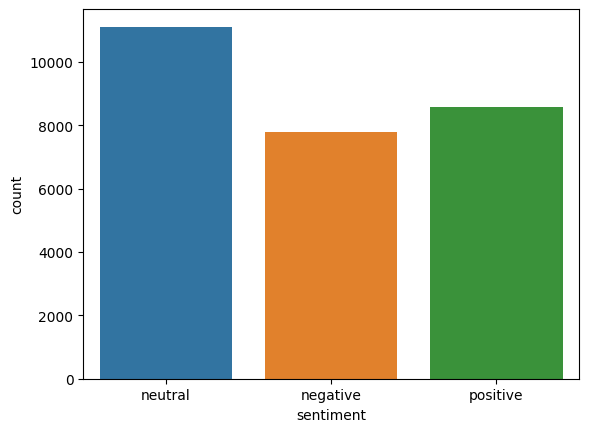

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check class distribution
sns.countplot(x=df['sentiment'])
plt.show()


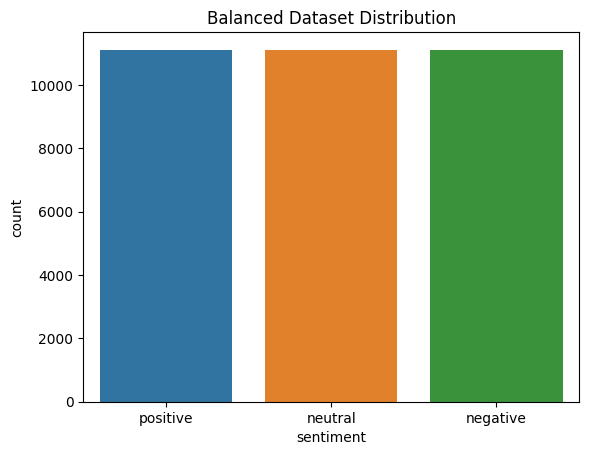

In [34]:
from sklearn.utils import resample

# Separate classes
df_neutral = df[df['sentiment'] == "neutral"]  # Majority class
df_negative = df[df['sentiment'] == "negative"]
df_positive = df[df['sentiment'] == "positive"]

# Oversample minority classes
df_negative_oversampled = resample(df_negative, replace=True, n_samples=len(df_neutral), random_state=42)
df_positive_oversampled = resample(df_positive, replace=True, n_samples=len(df_neutral), random_state=42)

# Combine all classes
df_balanced = pd.concat([df_neutral, df_negative_oversampled, df_positive_oversampled])

# Shuffle the data
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new class distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=df_balanced['sentiment'])
plt.title("Balanced Dataset Distribution")
plt.show()


In [35]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Tokenization
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_balanced["text"])

# Convert text to sequences
X = tokenizer.texts_to_sequences(df_balanced["text"])
X = pad_sequences(X, maxlen=100, padding="post", truncating="post")

# Encode labels (negative=0, neutral=1, positive=2)
label_map = {"negative": 0, "neutral": 1, "positive": 2}
df_balanced["sentiment_encoded"] = df_balanced["sentiment"].map(label_map)
y = np.array(df_balanced["sentiment_encoded"])

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Bidirectional

# Modify model architecture
model = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=100),
    Bidirectional(LSTM(128, return_sequences=True)),  
    Dropout(0.6),
    Bidirectional(LSTM(64)),
    Dropout(0.6),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

# Compile with same optimizer
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

# Add Early Stopping & LR Scheduler
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)
]

# Retrain with callbacks
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), callbacks=callbacks)


Epoch 1/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.5110 - loss: 0.9262 - val_accuracy: 0.7648 - val_loss: 0.5843 - learning_rate: 0.0010
Epoch 2/20
343/417 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8211 - loss: 0.4811

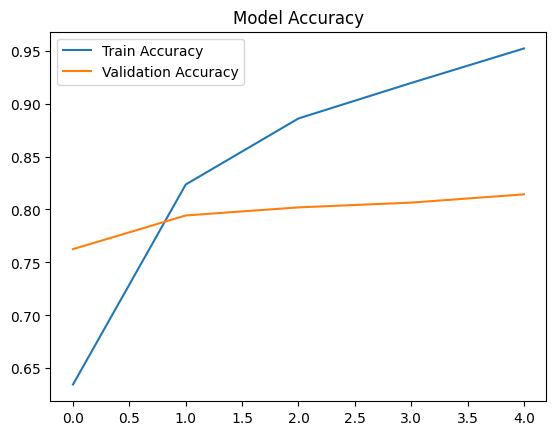

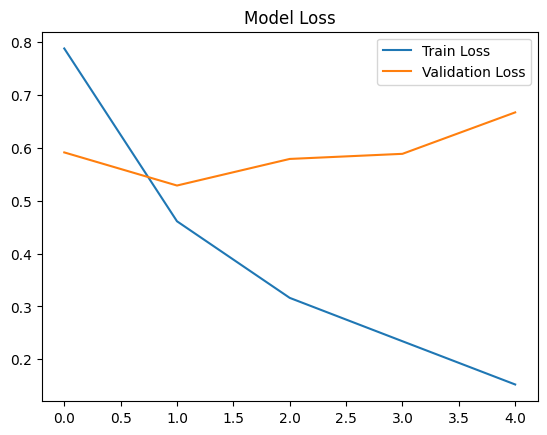

In [10]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Model Accuracy")
plt.show()

# Plot loss
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Model Loss")
plt.show()


In [23]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score

def predict_sentiment_and_evaluate(model, tokenizer, test_file, max_len):
    # Load test data
    test_df = pd.read_csv(test_file, encoding="ISO-8859-1")

    # Ensure column names are correct
    if 'text' not in test_df.columns or 'sentiment' not in test_df.columns:
        raise ValueError("Columns 'text' and 'sentiment' must be present in the test file.")

    # Handle NaN values in 'text' and 'sentiment'
    test_df = test_df.dropna(subset=['text', 'sentiment'])

    # Convert text to sequences
    test_sequences = tokenizer.texts_to_sequences(test_df['text'])
    test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

    # Predict sentiment
    predictions = model.predict(test_padded)
    predicted_labels = np.argmax(predictions, axis=1)

    # Convert numeric labels back to text (positive, neutral, negative)
    label_mapping = {0: "negative", 1: "neutral", 2: "positive"}
    test_df['predicted_sentiment'] = [label_mapping[label] for label in predicted_labels]

    # Calculate accuracy
    true_labels = test_df['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    return test_df[['text', 'sentiment', 'predicted_sentiment']]

# Example usage
test_file_path = "/kaggle/input/sentiment-analysis-dataset/test.csv"
result_df = predict_sentiment_and_evaluate(model, tokenizer, test_file_path, max_len=100)
print(result_df.head())  # Show sample predictions

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Accuracy: 68.42%
                                                text sentiment  \
0  Last session of the day  http://twitpic.com/67ezh   neutral   
1   Shanghai is also really exciting (precisely -...  positive   
2  Recession hit Veronique Branquinho, she has to...  negative   
3                                        happy bday!  positive   
4             http://twitpic.com/4w75p - I like it!!  positive   

  predicted_sentiment  
0             neutral  
1            positive  
2            negative  
3            positive  
4             neutral  
